<H2> COLETAR DADOS <H2>

<h3> Nessa seção vamos coletar os dados da Api.Pix banco central


In [62]:
import pandas as pd
import requests
import matplotlib 

In [63]:
urls_2023 = {
    "chavespix": "https://olinda.bcb.gov.br/olinda/servico/Pix_DadosAbertos/versao/v1/odata/ChavesPix(Data=@Data)?@Data='2023-01-01'&$top=100&$format=json",
    "estatisticas": "https://olinda.bcb.gov.br/olinda/servico/Pix_DadosAbertos/versao/v1/odata/TransacoesPixPorMunicipio(DataBase=@DataBase)?@DataBase='2023'&$top=100&$format=json",
    "transacoes_municipio": "https://olinda.bcb.gov.br/olinda/servico/Pix_DadosAbertos/versao/v1/odata/TransacoesPixPorMunicipio(DataBase=@DataBase)?@DataBase='2023'&$top=100&$format=json"
}


In [64]:
def consultar_dados_pix(url, data):
    try:
        resp = requests.get(url)
        resp.raise_for_status()
        dados_json = resp.json()
        registros = dados_json.get("value", [])
        if not registros:
            print(f"Atenção: Nenhum dado encontrado para {data} na URL {url}")
            return pd.DataFrame()
        df = pd.DataFrame(registros)
        # Adiciona coluna data referência
        df["data_referencia"] = pd.to_datetime(data, errors='coerce')
        return df
    except Exception as e:
        print(f"Erro ao consultar dados para {data}: {e}")
        return pd.DataFrame()


In [65]:
# Datas/anos para coleta
anos = ["2023-01-01", "2024-01-01", "2025-01-01"]


In [67]:
dados_completos = {
    "chavespix": pd.DataFrame(),
    "estatisticas": pd.DataFrame(),
    "transacoes_municipio": pd.DataFrame()
}


In [68]:
for ano in anos:
    print(f"Consultando dados para {ano}...")
    for chave, template_url in url_templates.items():
        # Substituir placeholder {{DATA}} na URL
        url = template_url.replace("{{DATA}}", ano if chave == "chavespix" else ano[:4])
        df = consultar_dados_pix(url, ano)
        if not df.empty:
            dados_completos[chave] = pd.concat([dados_completos[chave], df], ignore_index=True)


Consultando dados para 2023-01-01...
Consultando dados para 2024-01-01...
Consultando dados para 2025-01-01...


In [69]:
def tratar_df(df, renomear_cols):
    # Renomear colunas
    df = df.rename(columns=renomear_cols)

    # Verificar dados faltantes
    print("\nDados faltantes por coluna:")
    print(df.isnull().sum())

    # Ajustar tipos (exemplo: datas)
    if "data_referencia" in df.columns:
        df["data_referencia"] = pd.to_datetime(df["data_referencia"], errors='coerce')

    # Padronizar nomes de colunas para minúsculo e sem espaços
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    
    return df

In [70]:
renomear_transacoes = {
    "municipio_ibge": "municipio_ibge",
    "municipio": "municipio",
    "estado_ibge": "estado_ibge",
    "estado": "estado",
    "sigla_regiao": "sigla_regiao",
    "regiao": "regiao",
    "vl_pagadorpf": "vl_pagadorpf",
    "qt_pagadorpf": "qt_pagadorpf",
    "vl_pagadorpj": "vl_pagadorpj",
    "qt_pagadorpj": "qt_pagadorpj",
    "vl_recebedorpf": "vl_recebedorpf",
    "qt_recebedorpf": "qt_recebedorpf",
    "vl_recebedorpj": "vl_recebedorpj",
    "qt_recebedorpj": "qt_recebedorpj",
    "qt_pes_pagadorpf": "qt_pes_pagadorpf",
    "qt_pes_pagadorpj": "qt_pes_pagadorpj",
    "qt_pes_recebedorpf": "qt_pes_recebedorpf",
    "qt_pes_recebedorpj": "qt_pes_recebedorpj",
    "data_referencia": "data_referencia"
}


In [71]:
df_transacoes = tratar_df(dados_completos["transacoes_municipio"], renomear_transacoes)


Dados faltantes por coluna:
AnoMes                0
Municipio_Ibge        0
Municipio             0
Estado_Ibge           0
Estado                0
Sigla_Regiao          0
Regiao                0
VL_PagadorPF          0
QT_PagadorPF          0
VL_PagadorPJ          0
QT_PagadorPJ          0
VL_RecebedorPF        0
QT_RecebedorPF        0
VL_RecebedorPJ        0
QT_RecebedorPJ        0
QT_PES_PagadorPF      0
QT_PES_PagadorPJ      0
QT_PES_RecebedorPF    0
QT_PES_RecebedorPJ    0
data_referencia       0
dtype: int64


In [74]:
# Mostrar colunas para checar nomes
print(df_transacoes.columns)

# Criar coluna total_transacoes
df_transacoes["total_transacoes"] = (
    df_transacoes["qt_pagadorpf"].fillna(0) +
    df_transacoes["qt_pagadorpj"].fillna(0) +
    df_transacoes["qt_recebedorpf"].fillna(0) +
    df_transacoes["qt_recebedorpj"].fillna(0)
)

# Agora sim agrupar e somar
top_municipios = (
    df_transacoes.groupby("municipio")["total_transacoes"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print(top_municipios)


Index(['anomes', 'municipio_ibge', 'municipio', 'estado_ibge', 'estado',
       'sigla_regiao', 'regiao', 'vl_pagadorpf', 'qt_pagadorpf',
       'vl_pagadorpj', 'qt_pagadorpj', 'vl_recebedorpf', 'qt_recebedorpf',
       'vl_recebedorpj', 'qt_recebedorpj', 'qt_pes_pagadorpf',
       'qt_pes_pagadorpj', 'qt_pes_recebedorpf', 'qt_pes_recebedorpj',
       'data_referencia', 'total_transacoes'],
      dtype='object')
municipio
VITÓRIA DO XINGU        6177390
MIRADOR                 5796300
NOVO GAMA               4825085
UBIRATÃ                 4316607
CORBÉLIA                4216203
COLORADO                3530737
CONSELHEIRO LAFAIETE    3501204
SANTA MARIA DO OESTE    3107330
IRANDUBA                2835596
BUENOS AIRES            2824640
Name: total_transacoes, dtype: int64


In [75]:
top_municipios = (
    df_transacoes.groupby("municipio")["total_transacoes"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print("\nTop 10 municípios com mais transações Pix (2023-2025):")
print(top_municipios)


Top 10 municípios com mais transações Pix (2023-2025):
municipio
VITÓRIA DO XINGU        6177390
MIRADOR                 5796300
NOVO GAMA               4825085
UBIRATÃ                 4316607
CORBÉLIA                4216203
COLORADO                3530737
CONSELHEIRO LAFAIETE    3501204
SANTA MARIA DO OESTE    3107330
IRANDUBA                2835596
BUENOS AIRES            2824640
Name: total_transacoes, dtype: int64


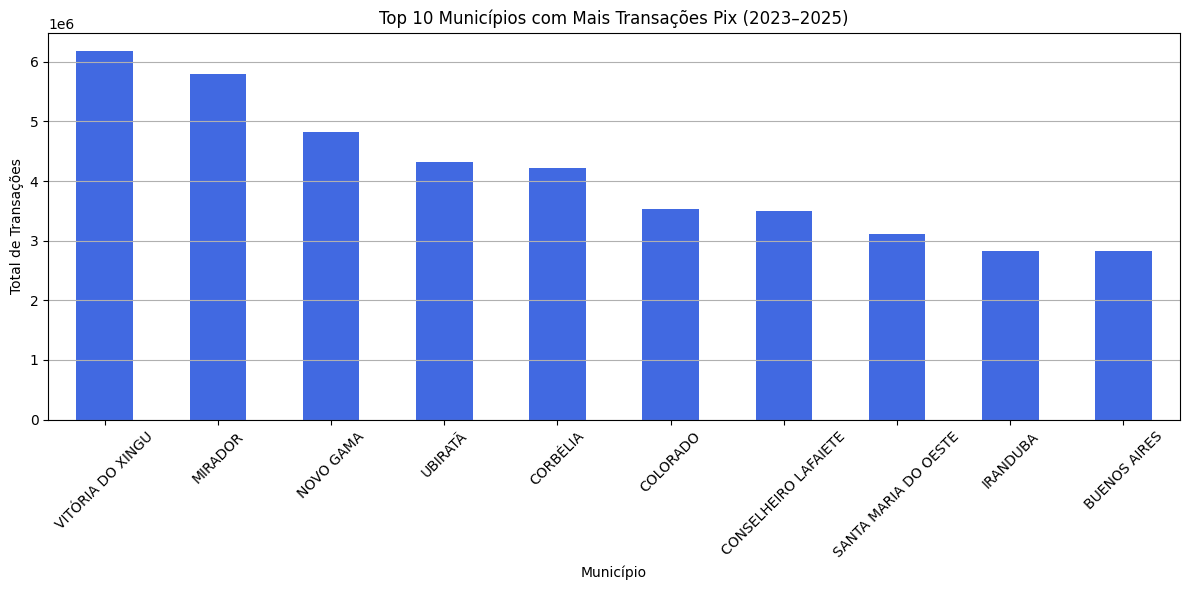

In [76]:
plt.figure(figsize=(12, 6))
top_municipios.plot(kind="bar", color="royalblue")
plt.title("Top 10 Municípios com Mais Transações Pix (2023–2025)")
plt.xlabel("Município")
plt.ylabel("Total de Transações")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
